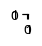

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# VAE comparisons (CDR3 vs Full TCR)

## Reconstructions

In [138]:
from joblib import Parallel, delayed
from functools import partial
MAXLENS={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}
def split_seq(seq, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    rec_seq = []
    i=0
    for name,length in max_lens.items():
        if length==0:
            continue
        rec_seq.append(seq[i:i+length].rstrip('X'))
        i+=length
    return rec_seq

def get_all_split(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df=df.copy()
    df.drop(columns=[x for x in df.columns if x.startswith('z_')], inplace=True)
    df[list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['true_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    df[list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['hat_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    return df
    
def get_cdr_acc(true, rec):
    if len(true)==len(rec):
        return np.mean([x==y for x,y in zip(true,rec)])
    elif len(true)>len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(true)-len(rec))*'X')])
    elif len(true)<len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(rec)-len(true))*'X')])
    else:
        return 0
        
def get_per_seq_acc(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df = df.copy()
    df = get_all_split(df, max_lens)
    true_cols=list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)
    rec_cols=list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)
    for true, rec in zip(true_cols, rec_cols):
        chain = true.rstrip('_true_rec')
        df[f'acc_{chain}'] =  df.apply(lambda x: get_cdr_acc(x[true], x[rec]), axis=1)
    return df

In [140]:
cdr3_valid.head()

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,...,hat_reconstructed,true_reconstructed,n_errors_seq,fold,A3_true_rec,B3_true_rec,A3_hat_rec,B3_hat_rec,acc_A3,acc_B3
0,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,0,1,...,IASQGGSEKLVXXXXXXXXXXXASSLRDGSEAFXXXXXXXXXXXX,IQSQGGSEKLVXXXXXXXXXXXASSLRDGSEAFXXXXXXXXXXXX,1,0,IQSQGGSEKLV,ASSLRDGSEAF,IASQGGSEKLV,ASSLRDGSEAF,0.909091,1.000000
1,YLYALVYFL,TSDPSYG,QGSYDQQN,AMREGKNDYKLS,SGHDT,YYEEEE,ASSFGGVEGMNTEAF,HLA-A*02:01,0,1,...,AMREGKNDYKLSXXXXXXXXXXASSFGGVEGLNTEAFXXXXXXXX,AMREGKNDYKLSXXXXXXXXXXASSFGGVEGMNTEAFXXXXXXXX,1,0,AMREGKNDYKLS,ASSFGGVEGMNTEAF,AMREGKNDYKLS,ASSFGGVEGLNTEAF,1.000000,0.933333
2,KLSALGINAV,TSESDYY,QEAYKQQN,AWRGGGGADGLT,MNHEY,SVGEGT,ASSWDPTYNEQF,HLA-A*02:01,0,1,...,AYRGGGGADGLTXXXXXXXXXXASSWDPTYNEQFXXXXXXXXXXX,AWRGGGGADGLTXXXXXXXXXXASSWDPTYNEQFXXXXXXXXXXX,1,0,AWRGGGGADGLT,ASSWDPTYNEQF,AYRGGGGADGLT,ASSWDPTYNEQF,0.916667,1.000000
3,IVTDFSVIK,NIATNDY,GYKTK,LVGDGSNYQLI,SGHAT,FQNNGV,ASSWGGGSHYGYT,HLA-A*11:01,0,1,...,IVGDGSNYQLIXXXXXXXXXXXASSWGGGSHYGYTXXXXXXXXXX,LVGDGSNYQLIXXXXXXXXXXXASSWGGGSHYGYTXXXXXXXXXX,1,0,LVGDGSNYQLI,ASSWGGGSHYGYT,IVGDGSNYQLI,ASSWGGGSHYGYT,0.909091,1.000000
4,CINGVCWTV,NSMFDY,ISSIKDK,AASARGQAGTALI,SGDLS,YYNGEE,ASSGPGGGAF,HLA-A*02:01,0,1,...,AASARGQAGTALIXXXXXXXXXASSGPGGGAFXXXXXXXXXXXXX,AASARGQAGTALIXXXXXXXXXASSGPGGGAFXXXXXXXXXXXXX,0,0,AASARGQAGTALI,ASSGPGGGAF,AASARGQAGTALI,ASSGPGGGAF,1.000000,1.000000


In [193]:
md=load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd.pt', 
                '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd_JSON_kwargs.json', 
               map_location='cpu')

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
Reloading best model:
Best epoch: 3536
total: 0.13724216025097188
reconstruction: 0.05977315063963867
kld: 0.0
triplet: 0.0
BCE: 0.07746901008453719
seq_accuracy: 0.995002806186676
pos_accuracy: 0.9974380135536194
auc: 0.72777
auc_01: 0.61584
auc_01_real: 0.27009
precision: 0.78755
recall: 0.18715
accuracy: 0.85567
AP: 0.44383


In [194]:
md

TwoStageCNNVAECLF(
  (vae): CNNVAE(
    (encoder): CNNEncoder(
      (conv_layers): Sequential(
        (0): Conv1d(26, 128, kernel_size=(9,), stride=(4,), padding=(2,))
        (1): SELU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(128, 256, kernel_size=(9,), stride=(4,), padding=(2,))
        (4): SELU()
        (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
      (fc_logvar): Linear(in_features=1024, out_features=128, bias=True)
    )
    (decoder): CNNDecoder(
      (conv_transpose_layers): Sequential(
        (0): ConvTranspose1d(256, 128, kernel_size=(9,), stride=(4,), padding=(2,), output_padding=(1,))
        (1): SELU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ConvTranspose1d(128, 26, kernel_size=(9,), stride=(4,), padding=(2,))

In [139]:
# read the prediction files 
cdr3_valid = get_per_seq_acc(pd.read_csv('../output/240618_NestedKCV_CNNVAE/Nested_OneStage_NoTriplet_CDR3ONLY_CNNVAE_ld64_KFold_0_240911_1631_PwCfM/valid_predictions_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_OneStage_NoTriplet_CDR3ONLY_CNNVAE_ld64_KFold_0_240911_1631_PwCfM.csv'),
                             max_lens={'A3':22, 'B3':23})
cdr3_test = get_per_seq_acc(pd.read_csv('../output/240618_NestedKCV_CNNVAE/Nested_OneStage_NoTriplet_CDR3ONLY_CNNVAE_ld64_KFold_0_240911_1631_PwCfM/test_predictions_240618_nettcr_exp_nested_posonly_test_p1_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_OneStage_NoTriplet_CDR3ONLY_CNNVAE_ld64_KFold_0_240911_1631_PwCfM.csv'),
                            max_lens={'A3':22, 'B3':23})
ftcr_valid = get_per_seq_acc(pd.read_csv('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/valid_predictions_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.csv'))
ftcr_test = get_per_seq_acc(pd.read_csv('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/test_predictions_240618_nettcr_exp_nested_posonly_test_p1_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.csv'))

In [141]:
COLS= ['partition', 'peptide', 'A1','A2','A3','B1','B2','B3', 
       'A1_hat_rec','A2_hat_rec','A3_hat_rec', 'B1_hat_rec', 'B2_hat_rec', 'B3_hat_rec', 
       'acc_A1', 'acc_A2', 'acc_A3', 'acc_B1', 'acc_B2', 'acc_B3', 'seq_acc']

cdr3_valid = cdr3_valid[[x for x in COLS if x in cdr3_valid.columns]]
cdr3_test = cdr3_test[[x for x in COLS if x in cdr3_test.columns]]
ftcr_valid = ftcr_valid[[x for x in COLS if x in ftcr_valid.columns]]
ftcr_test = ftcr_test[[x for x in COLS if x in ftcr_test.columns]]

In [142]:
cdr3_valid
cdr3_test
ftcr_valid
ftcr_test

,partition,peptide,A1,A2,A3,B1,B2,B3,A1_hat_rec,A2_hat_rec,...,B1_hat_rec,B2_hat_rec,B3_hat_rec,acc_A1,acc_A2,acc_A3,acc_B1,acc_B2,acc_B3,seq_acc
0,1,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,ATGYPS,ATKADDK,...,MDHEN,SYDVKM,ASSLAGGIVDEQF,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1,1,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,DRGSQS,IYSNGD,...,LGHNA,YSLEER,ASSRALLMGNTIY,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
2,1,IVTDFSVIK,YGATPY,YFSGDTLV,AVVQMNSGGYQKVT,MDHEN,SYDVKM,ATRPAGYNEQF,YGATPY,YFSGDTLV,...,MDHEN,SYDVKM,ATRPAGYNEQF,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
3,1,YLGGMSYYC,NSAFQY,TYSSGN,AMTWGGTSYGKLT,DFQATT,SNEGSKA,SAIEEGTEVFGYT,NSAFQY,TYSSGN,...,DFQATT,SNEGSKA,SAIEEGTEVFGYT,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
4,1,KLGGALQAK,DRGSQS,IYSNGD,AVNGGGFGNVLHCFGNVLH,SGHTA,FQGTGA,ASSSGAYNEQF,DRGSQS,IYSNGD,...,SGHTA,FQGTGA,ASSSGAYNEQF,1.0,1.0,0.947368,1.0,1.0,1.0,0.981132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,1,RAKFKQLL,TSGFNG,NVLDGL,AVRDPGRDYKLS,DFQATT,SNEGSKA,SARGHETTGELF,TSGFNG,NVLDGL,...,DFQATT,SNEGSKA,SARGHETTGELF,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1953,1,RAKFKQLL,NSASDY,IRSNMDK,ADSGGGADGLT,SGHDT,YYEEEE,ASSLGASMNTEAF,NSASDY,IRSNMDK,...,SGHDT,YYEEEE,ASSLGASMNTEAF,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1954,1,NLVPMVATV,SSNFYA,MTLNGDE,ASPTGNQFY,MNHEY,SMNVEV,ASSFTLGTGGVEQY,SSNFYA,MTLNGDE,...,MNHEY,SMNVEV,ASSFTLGTGGVEQY,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1955,1,IVTDFSVIK,SIFNT,LYKAGEL,AGHTGNQFY,MDHEN,SYDVKM,ASSLNGQGAGYT,SIFNT,LYKAGEL,...,MDHEN,SYDVKM,ASSLNGQGAGYT,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000


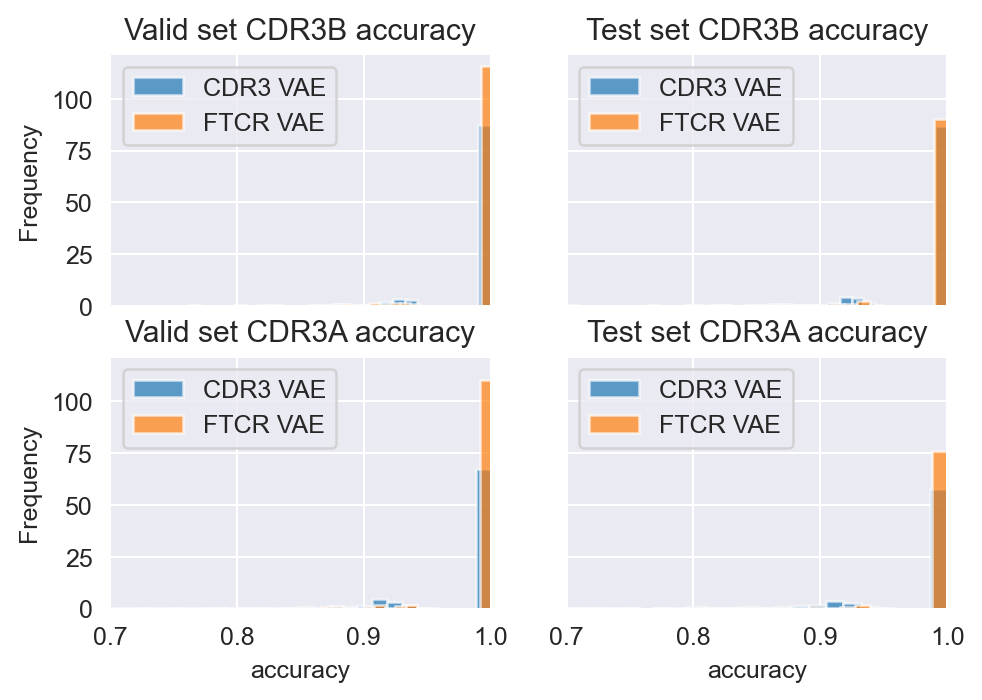

In [173]:
f,a = plt.subplots(2,2, figsize=(22,15), sharex=True, sharey=True)
ax = a.ravel()
cdr3_test['acc_B3'].plot(kind='hist', bins=60, figsize=(6,4), label='CDR3 VAE', ax=ax[1], alpha=0.7, xlim=[0.7, 1.], density=True)
ftcr_test['acc_B3'].plot(kind='hist', bins=60, figsize=(6,4), label='FTCR VAE', ax=ax[1], alpha=0.7, xlim=[0.7, 1.], density=True)
cdr3_valid['acc_B3'].plot(kind='hist', bins=60, figsize=(6,4), label='CDR3 VAE', ax=ax[0], alpha=0.7, xlim=[0.7,1.], density=True)
ftcr_valid['acc_B3'].plot(kind='hist', bins=60, figsize=(6,4), label='FTCR VAE', ax=ax[0], alpha=0.7, xlim=[0.7,1.], density=True)
cdr3_test['acc_A3'].plot(kind='hist', bins=60, figsize=(6,4), label='CDR3 VAE', ax=ax[2], alpha=0.7, xlim=[0.7, 1.], density=True)
ftcr_test['acc_A3'].plot(kind='hist', bins=60, figsize=(6,4), label='FTCR VAE', ax=ax[2], alpha=0.7, xlim=[0.7, 1.], density=True)
cdr3_valid['acc_A3'].plot(kind='hist', bins=60, figsize=(6,4), label='CDR3 VAE', ax=ax[3], alpha=0.7, xlim=[0.7,1.], density=True)
ftcr_valid['acc_A3'].plot(kind='hist', bins=60, figsize=(6,4), label='FTCR VAE', ax=ax[3], alpha=0.7, xlim=[0.7,1.], density=True)
ax[0].set_title('Valid set CDR3B accuracy')
ax[0].set_xlabel('accuracy')
ax[1].set_title('Test set CDR3B accuracy')
ax[1].set_xlabel('accuracy')
ax[2].set_title('Valid set CDR3A accuracy')
ax[2].set_xlabel('accuracy')
ax[3].set_title('Test set CDR3A accuracy')
ax[3].set_xlabel('accuracy')
ax[0].legend(loc ='upper left')
ax[1].legend(loc ='upper left')
ax[2].legend(loc ='upper left')
ax[3].legend(loc ='upper left')

In [191]:
from src.utils import flatten_level_columns
ftcr = pd.concat([ftcr_test.assign(Dataset='test'), ftcr_valid.assign(Dataset='valid')])
cdr3 = pd.concat([cdr3_test.assign(Dataset='test'), cdr3_valid.assign(Dataset='valid')])
total=pd.concat([ftcr.assign(Model='Full TCR'), cdr3.assign(Model='CDR3s')])
total_gb = total.groupby(['Model', 'Dataset'])[[x for x in total.columns if "acc" in x]].describe()
drop_cols = [x for x in total_gb.describe().columns if x[1] in ['count', '25%', '50%', '75%']]
total_gb = flatten_level_columns(total_gb.drop(columns=drop_cols))
total_gb = total_gb.round(5)
total_gb.T.to_csv('../../../writing/VAE_TCR_DRAFT/tables/240919_reconstruction_accuracies.csv')

# TCRbase comparisons

In [ ]:
def read_tcrbase_results(peptide, original_df, dir='../output/TCRBASE/tcrbase_expanded_p0_swapped/'):
    cols = ['bs1', 'bs2', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs3', 'bs4', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs5']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', 
                     header=None, names = cols).drop(columns=[f'bs{i}' for i in range(1,6)])
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'original_peptide', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
    
def read_tcrvae_results(peptide, original_df, dir):
    csv_file = glob.glob(f'{dir}*{peptide}*.csv')[0]
    df = pd.read_csv(csv_file)
    df['binder']=df['label']
    df['score'] = 1- df['min_dist']
    metrics = {'peptide':peptide, 'method':'_'.join(os.path.basename(csv_file).split('_')[5:]), 
               'n_pos':len(original_df.query('original_peptide==@peptide and partition==0 and binder==0'))}
    metrics.update(get_metrics(df['label'], df['score']))
    return metrics, df

def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model

    
def read_tcrbase_results_folds(peptide, original_df, partition, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)

    template_df = original_df.query('partition==@partition and peptide==@peptide')
    template_df = template_df.set_index('fulltcr')[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']]
    df['fulltcr'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    results = pd.merge(df.set_index('fulltcr')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       template_df, left_index=True, right_index=True)
    return results

def get_tcrbase_concat(peptide, original_df, dir):
    df = pd.concat([read_tcrbase_results_folds(peptide, original_df, partition, dir) for partition in range(5)])
    df['score_scaled'] = df['score'] / 12
    res = {'peptide':peptide}
    res.update(get_metrics(df['binder'], df['score_scaled'], no_curves=True))
    return res

In [ ]:
def read_tcrbase_results(peptide, original_df, partition=0, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    original_df = original_df.query('peptide==@peptide and partition==@partition')
    original_df['q_seq'] = original_df['A1']+original_df['A2']+original_df['A3']+original_df['B1']+original_df['B2']+original_df['B3']
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==@partition'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
        

In [106]:
exp_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
exp_df['tcr'] = exp_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
exp_df.drop_duplicates(subset='tcr')

,Unnamed: 0,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type,tcr
0,3,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,tcr_pep,ATGYPSATKADDKALSGNTDKLIMDHENSYDVKMASSLAGGIVDEQF
1,16,RLPGVLPRA,SSVSVY,YLSGSTLV,AVSPYNNNDMR,SGHNS,FNNNVP,ASRPLAAQETQY,HLA-A*02:01,4,1,VDJdb,RLPGVLPRA,VDJdb_73754,33811047,HomoSapiens,tcr_pep,SSVSVYYLSGSTLVAVSPYNNNDMRSGHNSFNNNVPASRPLAAQETQY
2,34,LLDFVRFMGV,KTLYG,LQKGGEE,GADGNFNKFY,MNHEY,SVGAGI,ASSQWGQGRETQY,HLA-A*02:01,4,1,10x,LLDFVRFMGV,ITRAP_4812,37133356,NaN,tcr_pep,KTLYGLQKGGEEGADGNFNKFYMNHEYSVGAGIASSQWGQGRETQY
3,42,VYFLQSINF,SSVSVY,YLSGSTLV,AVSTNTGANSKLT,SGHDT,YYEEEE,ASSFRGLNQPQH,"HLA-A*02:01, HLA-A*24:02",3,1,IEDB,VYFLQSINF,IEDB_191829,34424997,SARS-CoV2,tcr_pep,SSVSVYYLSGSTLVAVSTNTGANSKLTSGHDTYYEEEEASSFRGLN...
4,49,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,HLA-A*02:01,1,1,10x,ELAGIGILTV,ITRAP_4414,37133356,NaN,tcr_pep,DRGSQSIYSNGDAAPQGAGTALILGHNAYSLEERASSRALLMGNTIY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,58583,NLVPMVATV,NYSPAY,IRENEKE,ALVTGYSTLT,SGHNT,YYREEE,ASSSGTSGSGSYNEQF,HLA-A*02:01,2,1,VDJdb,NLVPMVATV,VDJdb_6082,https://doi.org/10.1101/2020.05.04.20085779,CMV,tcr_pep,NYSPAYIRENEKEALVTGYSTLTSGHNTYYREEEASSSGTSGSGSY...
9765,58592,ELAGIGILTV,DRGSQS,IYSNGD,AVNWWEYGNKLV,DFQATT,SNEGSKA,SARDGTSAEY,HLA-A*02:01,3,1,10x,ELAGIGILTV,ITRAP_2417,37133356,NaN,tcr_pep,DRGSQSIYSNGDAVNWWEYGNKLVDFQATTSNEGSKASARDGTSAEY
9766,58603,GILGFVFTL,DRGSQS,IYSNGD,AVNQGGGSQGNLI,LNHDA,SQIVND,ASSFRAPYGYT,HLA-A*02:01,1,1,10x,GILGFVFTL,ITRAP_799,37133356,NaN,tcr_pep,DRGSQSIYSNGDAVNQGGGSQGNLILNHDASQIVNDASSFRAPYGYT
9767,58604,KLGGALQAK,SSNFYA,MTLNGDE,ALGRNEKLT,SGHRS,YFSETQ,ASSPEGSANTGELF,HLA-A*03:01,3,1,10x,KLGGALQAK,ITRAP_2434,37133356,NaN,tcr_pep,SSNFYAMTLNGDEALGRNEKLTSGHRSYFSETQASSPEGSANTGELF


In [130]:
%ls ../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/ | grep 4500

epoch_4500_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd.pt


python(27192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
